<h1 class="header"><img class="logo" src="../images/socib_logo.png" width="200px"></h1>

<h3> STYLING NOTEBOOK (OPTIONAL)</h3>

In [59]:
from IPython.core.display import HTML
import urllib2
HTML(urllib2.urlopen('https://raw.githubusercontent.com/socib/API_examples/master/style/custom/custom.css').read())

<h3> HANDY PYTHON PACKAGES </h3>

In [1]:
import requests
import json
from IPython.display import display, HTML, JSON
import matplotlib.pyplot as plt
import numpy as np
import datetime
from json2html import *
from IPython.display import HTML, display
%matplotlib inline

<h3> PREREQUISITES </h3>

In [13]:
api_key = '' #write you SOCIB api_key
api_url = 'http://api.socib.es'
headers = {
    'accept': 'application/vnd.socib+json',
    'apikey': api_key,
}

<h3> REQUESTING A DATA-SOURCE'S DATA <span>WITH PARAMS</span></h3>

As already seen in ['Subsetting a data-source's data'](subsetting_a_data_sources_data.ipynb), there are parameters that added to an endpoint allows applying some filtering over the generic answer: let's have a look to extra ones available for the <b>/data-sources/{id}/data</b> auxiliary endpoint and apply them to the a deployment.

<h3>1. FIND A DATA-SOURCE</h3>

Setting a certain time range, a defined area, a certain platform type and a certain variable to find a number of matching deployments:

In [14]:
time_range_start = '2016-04-15T15:00:00' # should match the notation YYYY-MM-DDTHH:MM:SS
time_range_end =  '2016-10-15T00:00:00' # should match the notation YYYY-MM-DDTHH:MM:SS
min_lat = 40.0#float
max_lat = 38.0 #float
min_lon = 0.0 #float
max_lon = 3.0#float
bbox = str(min_lat)+','+str(max_lat)+','+str(min_lon)+','+str(max_lon)
platform_type = 'Oceanographic Buoy'
variables = 'sea_water_temperature'

In [15]:
end_point = '/data-sources/'
url_addons = '?platform_type=%s&initial_datetime=%s&end_datetime=%s&standard_variable=%s&bbox=%s'%(platform_type,time_range_start,time_range_end, variables,bbox)
request = requests.get('%s%s%s' % (api_url, end_point,url_addons), headers=headers)
response = json.loads(request.text)
print('Requested url: '+'%s%s%s' % (api_url, end_point,url_addons))
print(" ")
print('A total of %s SOCIB deployments match the above searching criteria'% (response['count']))

Requested url: http://api.socib.es/data-sources/?platform_type=Oceanographic Buoy&initial_datetime=2016-04-15T15:00:00&end_datetime=2016-10-15T00:00:00&standard_variable=sea_water_temperature&bbox=40.0,38.0,0.0,3.0
 
A total of 12 SOCIB deployments match the above searching criteria


And choosing one of the above deployments, let's have a look to its metadata:

In [16]:
targeted_deployment = response['results'][2]#i.e deployment/data-source number 2 of the above page
metadata = {k:v for k, v in targeted_deployment.items() if k != 'entries'} #skipping the deployment data for later
HTML(json2html.convert(json=metadata))

<h3>2. REQUEST ITS DATA</h3>

Let's choose one of the above L1 variables by means of <b>/data-sources/{id}/data/ </b> auxiliary endpoint:

In [17]:
end_point_plus_aux = '/data-sources/'+targeted_deployment['id']+'/data/?processing_level=L1&standard_variable=sea_water_temperature'
request = requests.get('%s%s' % (api_url, end_point_plus_aux), headers=headers)
response = json.loads(request.text)
print('Requested url: '+'%s%s' % (api_url, end_point_plus_aux))

Requested url: http://api.socib.es/data-sources/26fafa7ff4/data/?processing_level=L1&standard_variable=sea_water_temperature


In [18]:
for level in response.keys():    
    variables_metadata = [{response[level]['features'][feature]['feature_type']: [{standard_variable: [{k:v for k, v in response[level]['features'][feature]['variables'][standard_variable][param].items() if k!='data'} for param in response[level]['features'][feature]['variables'][standard_variable].keys()]} for standard_variable in response[level]['features'][feature]['variables']]} for feature in range(0,len(response[level]['features']))]
    variables_per_level = {level: variables_metadata}
    display(HTML(json2html.convert(json=variables_per_level)))

<h3>3. PLOT ITS DATA</h3>

Let's have an quick overview of the complete deployment: 

In [19]:
def get_variable_matches(response, standard_name, level_type, feature_type):
    # explore a given /data-source/{id}/data/ response looking for a variable with a specific standard name,processing level and feature type
    level = response[level_type]
    features = [feature for feature in level['features'] if feature['feature_type'] == feature_type]
    variables = [feature['variables'][standard_name] for feature in features if standard_name in feature['variables'].keys()]
    matches = []
    for param in variables:
        for key in param.keys():
            try:
                matches.append({'units':param[key]['units'], 'data': param[key]['data']})
            except:
                matches.append({'units':'unknown', 'data': param[key]['data']})
    return matches;

In [20]:
def get_coordinate(response, name, level_type, feature_type):
    # explore a given /data-source/{id}/data/ response looking for a coordinate with a specific standard name,processing level and feature type
    level = response[level_type]
    features = [feature for feature in level['features'] if feature['feature_type'] == feature_type]
    coords = [feature['coordinates'][name] for feature in features if name in feature['coordinates'].keys()]
    matches = []
    for param in coords:
        try:
            matches.append({'units':param['units'], 'data': param['data']})
        except:
            matches.append({'units': 'unknown', 'data': param['data']})    
    return matches;

In [21]:
variable_name = 'sea_water_temperature'
coord_name_3 = 'time'

In [22]:
var = get_variable_matches(response, variable_name, 'L1', 'timeSeries')[0]
time = get_coordinate(response, coord_name_3, 'L1','timeSeries')[0]

In [23]:
time = np.array(time['data'], dtype=np.str)
var = np.array(var['data'],dtype=float)#dealing with None values

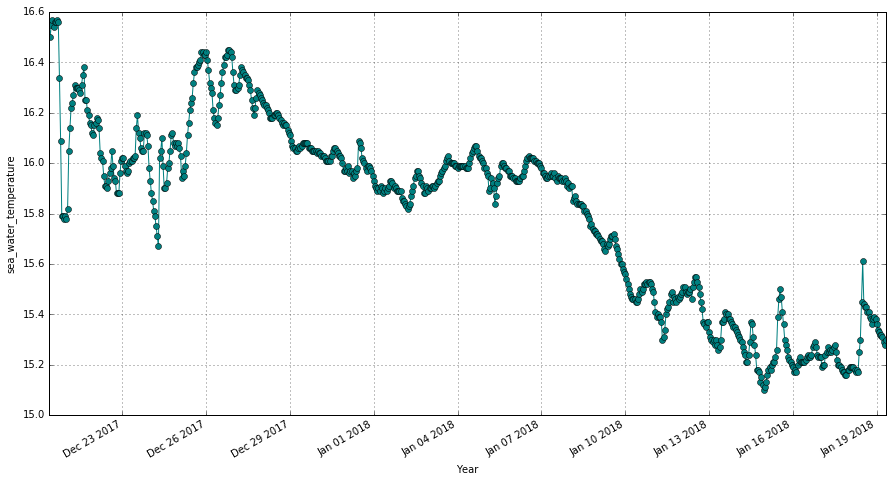

In [24]:
fig = plt.figure(figsize=(15, 8))
ax = fig.add_subplot(111)

time2 = [datetime.datetime.strptime(x, '%Y-%m-%dT%H:%M:%S') for x in time]
plt.plot(time2, var, color="teal", marker='o')
plt.ylabel(variable_name)
plt.xlabel('Year')
fig.autofmt_xdate()
plt.grid()
plt.show()

<h3>3. RESAMPLE ITS DATA</h3>

<ul><li><h3>RESAMPLE A DATA-SOURCE'S DATA BY <span>TIME WINDOW AND FORMULA </span></h3></li></ul>

Let's get the daily means from the above data:

In [25]:
resample_rule = 'D' 
resample_how ='mean'
end_point_plus_aux = '/data-sources/'+targeted_deployment['id']+'/data/?processing_level=L1&standard_variable=sea_water_temperature&max_qc_value=1&resample_how=%s&resample_rule=%s'%(resample_how, resample_rule)
request = requests.get('%s%s' % (api_url, end_point_plus_aux), headers=headers)
response = json.loads(request.text)
print('Requested url: '+'%s%s' % (api_url, end_point_plus_aux))

Requested url: http://api.socib.es/data-sources/26fafa7ff4/data/?processing_level=L1&standard_variable=sea_water_temperature&max_qc_value=1&resample_how=mean&resample_rule=D


In [26]:
var = get_variable_matches(response, variable_name, 'L1', 'timeSeries')[0]
time = get_coordinate(response, coord_name_3, 'L1','timeSeries')[0]

In [27]:
time = np.array(time['data'], dtype=np.str)
var = np.array(var['data'],dtype=float)#dealing with None values

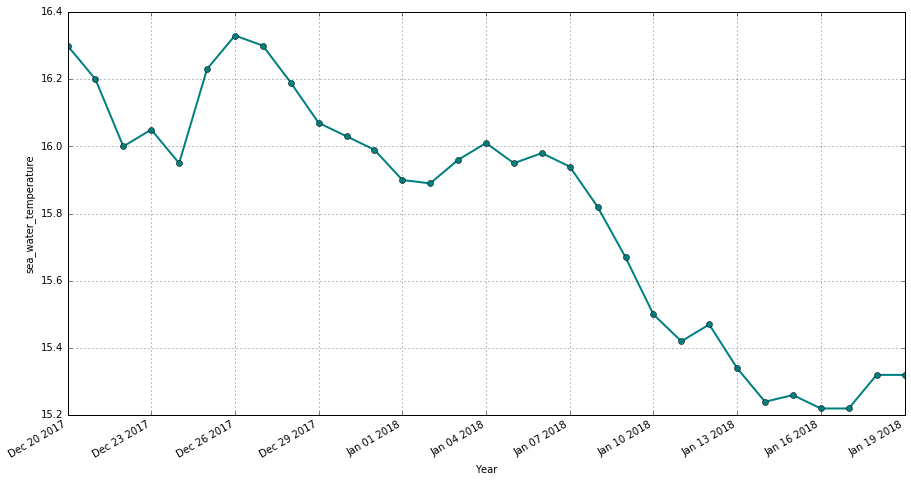

In [28]:
fig = plt.figure(figsize=(15, 8))
ax = fig.add_subplot(111)
time2 = [datetime.datetime.strptime(x, '%Y-%m-%dT%H:%M:%S') for x in time]
plt.plot(time2, var, linewidth=2, color="teal", marker='o')
plt.ylabel(variable_name)
plt.xlabel('Year')
fig.autofmt_xdate()
plt.grid()
plt.show()

See more about resampling rules and methods (how) at: [pandas documentation](http://pandas.pydata.org/pandas-docs/stable/timeseries.html#offset-aliases)

<ul><li><h3>RESAMPLE A DATA-SOURCE'S DATA BY <span>QC FLAG</span></h3></li></ul>

Let's check a different the time range than the above defaulting one (last month of data):

In [29]:
end_point_plus_aux = '/data-sources/'+targeted_deployment['id']+'/data/?initial_datetime=2016-04-15T15:00:00&end_datetime=2016-10-15T00:00:00&processing_level=L1&standard_variable=sea_water_temperature'
request = requests.get('%s%s' % (api_url, end_point_plus_aux), headers=headers)
response = json.loads(request.text)
print('Requested url: '+'%s%s' % (api_url, end_point_plus_aux))

Requested url: http://api.socib.es/data-sources/26fafa7ff4/data/?initial_datetime=2016-04-15T15:00:00&end_datetime=2016-10-15T00:00:00&processing_level=L1&standard_variable=sea_water_temperature


In [30]:
var = get_variable_matches(response, variable_name, 'L1', 'timeSeries')[0]
time = get_coordinate(response, coord_name_3, 'L1','timeSeries')[0]

In [31]:
time = np.array(time['data'], dtype=np.str)
var = np.array(var['data'],dtype=float)#dealing with None values

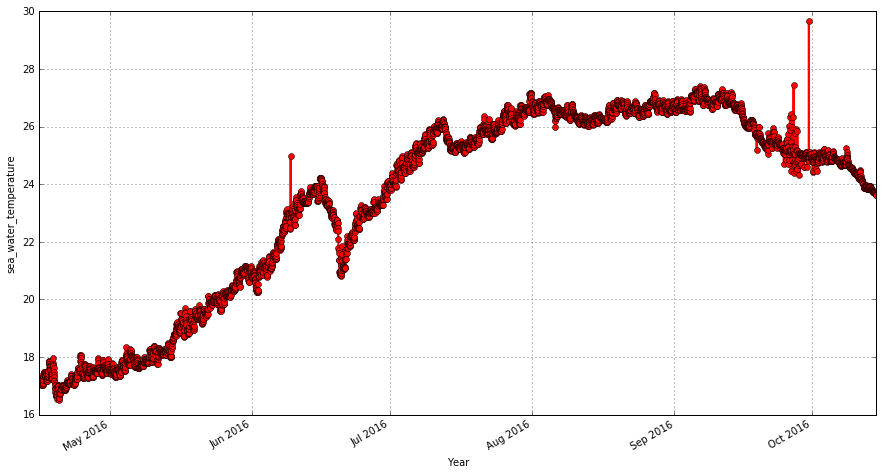

In [32]:
fig = plt.figure(figsize=(15, 8))
ax = fig.add_subplot(111)
time2 = [datetime.datetime.strptime(x, '%Y-%m-%dT%H:%M:%S') for x in time]
plt.plot(time2, var , linewidth=2, color="red", marker='o')
plt.ylabel(variable_name)
plt.xlabel('Year')
fig.autofmt_xdate()
plt.grid()
plt.show()

QC flags allow users to target reliable data among all the available and overlook outliers such as the ones above. You can find out more about QC flags at [Ocean Sites](http://www.oceansites.org/docs/oceansites_data_format_reference_manual.pdf).

Let's just keep the data with QC flag 1 ('Good data') and plot the above time range again:

In [33]:
end_point_plus_aux = '/data-sources/'+targeted_deployment['id']+'/data/?initial_datetime=2016-03-21T15:00:00&end_datetime=2016-10-15T00:00:00&processing_level=L1&standard_variable=sea_water_temperature&max_qc_value=1'
request = requests.get('%s%s' % (api_url, end_point_plus_aux), headers=headers)
response = json.loads(request.text)
print('Requested url: '+'%s%s' % (api_url, end_point_plus_aux))

Requested url: http://api.socib.es/data-sources/26fafa7ff4/data/?initial_datetime=2016-03-21T15:00:00&end_datetime=2016-10-15T00:00:00&processing_level=L1&standard_variable=sea_water_temperature&max_qc_value=1


In [34]:
var = get_variable_matches(response, variable_name, 'L1', 'timeSeries')[0]
time = get_coordinate(response, coord_name_3, 'L1','timeSeries')[0]

In [35]:
time = np.array(time['data'], dtype=np.str)
var = np.array(var['data'],dtype=float)#dealing with None values

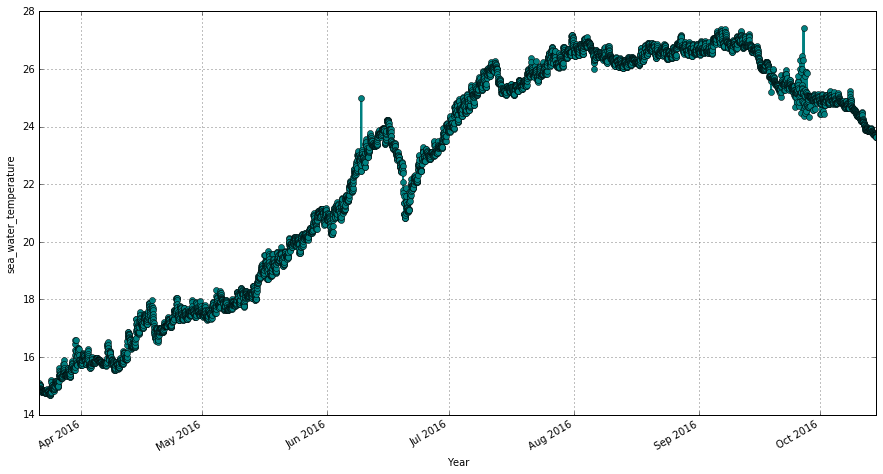

In [36]:
fig = plt.figure(figsize=(15, 8))
ax = fig.add_subplot(111)
time = [datetime.datetime.strptime(x, '%Y-%m-%dT%H:%M:%S') for x in time]
plt.plot(time, var , linewidth=2, color="teal", marker='o')
plt.ylabel(variable_name)
plt.xlabel('Year')
fig.autofmt_xdate()
plt.grid()
plt.show()